### PROYECTO FINAL

En este proyecto se trabajarán con los datos de la compañía Interconnect, que es un operador de telecomunicaciones.

- Problema a resolver:

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes.

Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales.

El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

In [1]:
#Importación de Librerías

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

c:\Users\antho\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
#Importación de dataframes

try:
    df_contract = pd.read_csv('contract.csv')
    df_internet = pd.read_csv('internet.csv')
    df_personal = pd.read_csv('personal.csv')
    df_phone = pd.read_csv('phone.csv')
except:
    df_contract = pd.read_csv('/datasets/contract.csv')
    df_internet = pd.read_csv('/datasets/internet.csv')
    df_personal = pd.read_csv('/datasets/personal.csv')
    df_phone = pd.read_csv('/datasets/phone.csv')

### Descripción de los datos

Los datos consisten en 4 archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente.

### Análisis exploratorio

### Dataframe 'contract'

In [3]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


- En este punto se descubrirá por qué 'TotalCharges' es tipo Object y no númerico.
- Se revisará si hay valores ausentes.

In [5]:
valores_unicos = df_contract['TotalCharges'].unique()
valores_unicos_ordenados = np.sort(valores_unicos)
print(valores_unicos_ordenados)

[' ' '100.2' '100.25' ... '999.45' '999.8' '999.9']


In [6]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


- Efectivamente la columna tiene valores ausentes, pero que en realidad el valor es un espacio (' '), por esto mismo, no se estaba considerando como un ausente propiamente tal.
- Estos valores vacíos son nuevos contratos que llevan menos de un mes, por lo que tiene sentido que no tengan un acumulado de cobros.

### Dataframe 'internet'

In [7]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


- Sobre este dataframe se puede mencionar que tiene menos filas que el de contrato, esto puede deberse a que no todos los usuarios han contratado el servicio de internet.

### Dataframe 'personal'

In [9]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


- Este dataframe muestra características personlas de los clientes, y las filas son las mismas que el df de contract, por lo que no hay valores ausentes.

### Dataframe 'phone'

In [11]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [12]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


- Sobre este dataframe se puede mencionar que tiene menos filas que el de contrato, esto puede deberse a que no todos los usuarios han contratado el servicio de teléfono.

### Consolidando los dataframes

In [13]:
df_consolidado = pd.merge(df_contract, df_internet, on='customerID', how='outer')
df_consolidado = pd.merge(df_consolidado, df_personal, on='customerID', how='outer')
df_consolidado = pd.merge(df_consolidado, df_phone, on='customerID', how='outer')

In [14]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [15]:
df_consolidado.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


### Corrección de formatos

- En el siguiente paso se convertirá la columna 'SeniorCitizen' al tiipo int8, que ahora es del tipo int64, esto con el fin de que al procesar los modelos, estos no tarden tanto tiempo, ni consuman tanta memoria.

In [16]:
df_consolidado['SeniorCitizen'] = df_consolidado['SeniorCitizen'].astype('int8')

- En el siguiente paso se convertirál algunos tipos object a category, esto con el fin de mejorar la eficiencia en el procesamiento.

In [17]:
df_consolidado = df_consolidado.astype({'Type': 'category', 'PaperlessBilling': 'category', 'PaymentMethod': 'category','InternetService': 'category','OnlineSecurity': 'category','OnlineBackup': 'category',
                                        'DeviceProtection': 'category', 'TechSupport': 'category', 'StreamingTV': 'category', 'StreamingMovies': 'category', 'gender': 'category',
                                        'Partner': 'category', 'Dependents': 'category', 'MultipleLines': 'category'})

In [18]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   BeginDate         7043 non-null   object  
 2   EndDate           7043 non-null   object  
 3   Type              7043 non-null   category
 4   PaperlessBilling  7043 non-null   category
 5   PaymentMethod     7043 non-null   category
 6   MonthlyCharges    7043 non-null   float64 
 7   TotalCharges      7043 non-null   object  
 8   InternetService   5517 non-null   category
 9   OnlineSecurity    5517 non-null   category
 10  OnlineBackup      5517 non-null   category
 11  DeviceProtection  5517 non-null   category
 12  TechSupport       5517 non-null   category
 13  StreamingTV       5517 non-null   category
 14  StreamingMovies   5517 non-null   category
 15  gender            7043 non-null   category
 16  SeniorCitizen     7043 n

- En este paso se convertirán los valores de la columna TotalCharge a float64, con el fin de poder comparalo con el valor del MonthlyCharges.

In [19]:
df_consolidado['TotalCharges'] = pd.to_numeric(df_consolidado['TotalCharges'], errors='coerce').astype('float64')

- En este paso se convertirán las columnas 'BeginDate' y  'EndDate' a un formato 'datetime', con el fin de poder hacer cálculos con esos valores.

In [20]:
df_consolidado['BeginDate'] = pd.to_datetime(df_consolidado['BeginDate'], format='%Y-%m-%d')
df_consolidado['EndDate'] = pd.to_datetime(df_consolidado['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [21]:
df_consolidado['EndDate'].unique()

<DatetimeArray>
[                'NaT', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
 '2019-10-01 00:00:00', '2020-01-01 00:00:00']
Length: 5, dtype: datetime64[ns]

In [22]:
df_consolidado.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


- Actualizando el formato de los encabezados a snake_case

In [23]:
df_consolidado = df_consolidado.rename(columns={'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date', 'Type': 'type','PaperlessBilling': 'paperless_billing', 'PaymentMethod': 'payment_method',
                                                'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges', 'InternetService': 'internet_service', 'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup',
                                                'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support', 'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies', 'gender': 'gender',
                                                'SeniorCitizen': 'senior_citizen', 'Partner': 'partner', 'Dependents': 'dependents', 'MultipleLines': 'multiple_lines'})

In [24]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   internet_service   5517 non-null   category      
 9   online_security    5517 non-null   category      
 10  online_backup      5517 non-null   category      
 11  device_protection  5517 non-null   category      
 12  tech_support       5517 non-null   category      
 13  streaming_tv       5517 non-null   category      
 14  streamin

### Valores Ausentes.
Los valores ausentes serán rellenados con No, porque se asumirá que los clientes no cuentan con esos servicios.

In [25]:
df_consolidado[df_consolidado['internet_service'].isnull()].head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
11,7469-LKBCI,2018-10-01,NaT,Two year,No,Credit card (automatic),18.95,326.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
16,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
21,1680-VDCWW,2019-02-01,NaT,One year,No,Bank transfer (automatic),19.80,202.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,No,No
22,1066-JKSGK,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
33,7310-EGVHZ,2020-01-01,NaT,Month-to-month,No,Bank transfer (automatic),20.20,20.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No


In [26]:
columnas = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
valor = 'No'

# Agrega la categoría 'No' a las columnas categóricas solo si no existe
for columna in columnas:
    if valor not in df_consolidado[columna].cat.categories:
        df_consolidado[columna] = df_consolidado[columna].cat.add_categories(valor)

# Llena los valores nulos con 'No'
df_consolidado[columnas] = df_consolidado[columnas].fillna(valor)


- Acá se rellenarán los valores ausente de 'total_charges' con ceros, recordemos que estos valores ausentes corresponden a usuarios que llevan menos de un mes en la compañía.

In [27]:
df_consolidado['total_charges'] = df_consolidado['total_charges'].fillna(0)

In [28]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   7043 non-null   category      
 9   online_security    7043 non-null   category      
 10  online_backup      7043 non-null   category      
 11  device_protection  7043 non-null   category      
 12  tech_support       7043 non-null   category      
 13  streaming_tv       7043 non-null   category      
 14  streamin

- En este paso se rellenarán los ausentes de 'end_date' con 'No'.

In [29]:
df_consolidado['end_date'] = df_consolidado['end_date'].fillna('No')

In [30]:
df_consolidado['end_date'].value_counts()

end_date
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

In [31]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   7043 non-null   category      
 9   online_security    7043 non-null   category      
 10  online_backup      7043 non-null   category      
 11  device_protection  7043 non-null   category      
 12  tech_support       7043 non-null   category      
 13  streaming_tv       7043 non-null   category      
 14  streamin

### Funciones para 'end_date'

- En este paso, agregaremos una columna con valores booleanos, en donde 0 representará los clientes que siguen en la compañía, y 1 a los clientes que dejaron la compañía.

In [32]:
def end_date_2(row):
    if row['end_date'] == 'No':
        return 0
    else:
        return 1
    
df_consolidado['end_date_2'] = df_consolidado.apply(end_date_2, axis=1)

In [33]:
df_consolidado['end_date_2'].unique()

array([0, 1], dtype=int64)

- A continuación se calcularán los meses de uso desde el inicio del contrato. Se utilizará la fecha 31-01-2020 como la fecha de hoy.

In [34]:
def end_date_3(row):
    if row['end_date'] == 'No':
        return pd.to_datetime('2020-01-31',format='%Y-%m-%d')
    else:
        return row['end_date']
    
df_consolidado['end_date_3'] = df_consolidado.apply(end_date_3, axis=1)

In [35]:
df_consolidado['end_date_3'].value_counts()

end_date_3
2020-01-31    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: count, dtype: int64

In [36]:
def months(row):
    months_diff = row['end_date_3'] - row['begin_date']
    return round(months_diff / pd.Timedelta(days=30))

df_consolidado['months_using_service'] = df_consolidado.apply(months, axis=1)

- Ahora, se calculará los cobros adicionales al cobro mensual, se hará calculand la diferencia entre 'total_charges' y 'monthly_charges' multiplicado por 'months_using_service', que serían los meses que el usuario ha usado el servicio.

In [37]:
def ttl_charges(row):
    total_charges_diff = (row['monthly_charges'] * row['months_using_service']) - row['total_charges']
    return total_charges_diff

df_consolidado['total_charges_diff'] = df_consolidado.apply(ttl_charges, axis=1)

In [38]:
df_consolidado.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,end_date_2,end_date_3,months_using_service,total_charges_diff
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,Female,0,Yes,No,No,0,2020-01-31,1,0.00
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,Male,0,No,No,No,0,2020-01-31,34,46.80
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,Male,0,No,No,No,1,2019-12-01,2,-0.45
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,No,Male,0,No,No,No,0,2020-01-31,46,105.05
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,Female,0,No,No,No,1,2019-11-01,2,-10.25


### Análisis a través de Gráficos

- Se iniciará el análisis de los datos a través de los gráficos, primero se analizará el dataframe 'contract'.

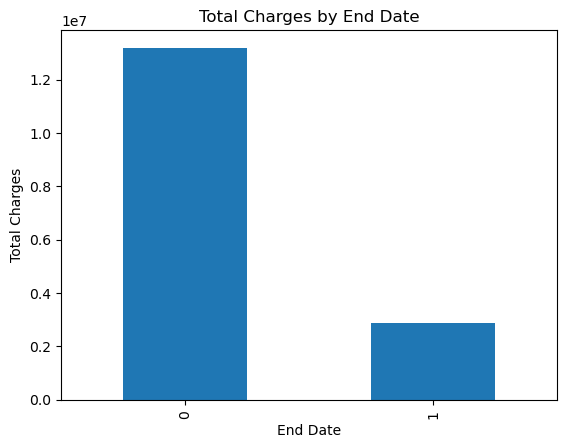

In [39]:
df_consolidado.groupby('end_date_2')['total_charges'].sum().plot(kind='bar')
plt.xlabel('End Date')
plt.ylabel('Total Charges')
plt.title('Total Charges by End Date')
plt.show()

In [40]:
df_consolidado['customer_id'].nunique()

7043

In [41]:
df_consolidado['total_charges'].sum()

16056168.7

In [42]:
(df_consolidado.groupby('end_date_2')['total_charges'].sum() / df_consolidado['total_charges'].sum()) * 100

end_date_2
0    82.169302
1    17.830698
Name: total_charges, dtype: float64

- Sobre los ingresos totales, se puede decir que de los 7043 clientes que se manejan en el dataframe, los que aún siguen en la compañía, aportan el 82% de la venta, siendo esta de un total de $16M. Sin embargo, la empresa quiere predecir qué clientes pueden dejar de contratar sus servicios, con el fin de disminuir el 18% de clientes perdidos.

### Analizando los métodos de pago

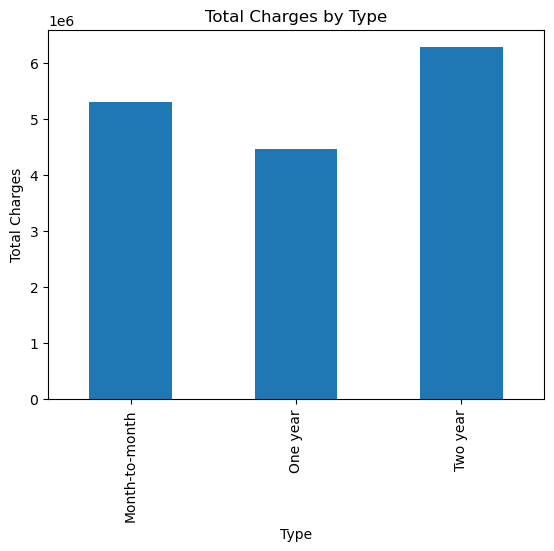

In [43]:
df_consolidado.groupby('type', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Total Charges')
plt.title('Total Charges by Type')
plt.show()

In [44]:
(df_consolidado.groupby('type', observed=False)['total_charges'].sum() / df_consolidado['total_charges'].sum()) * 100

type
Month-to-month    33.045626
One year          27.821416
Two year          39.132958
Name: total_charges, dtype: float64

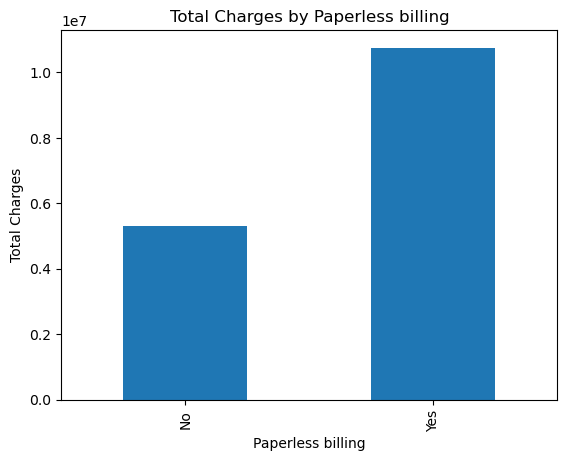

In [45]:
df_consolidado.groupby('paperless_billing', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Paperless billing')
plt.ylabel('Total Charges')
plt.title('Total Charges by Paperless billing')
plt.show()

In [46]:
(df_consolidado.groupby('paperless_billing', observed=False)['total_charges'].sum() / df_consolidado['total_charges'].sum()) * 100

paperless_billing
No     33.030165
Yes    66.969835
Name: total_charges, dtype: float64

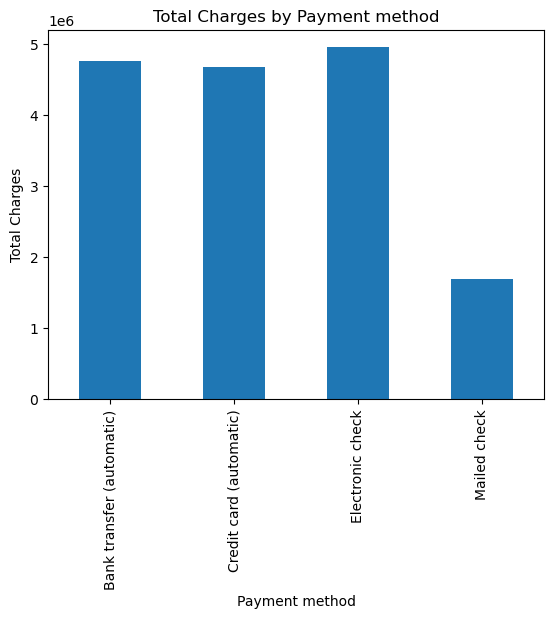

In [47]:
df_consolidado.groupby('payment_method', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Payment method')
plt.ylabel('Total Charges')
plt.title('Total Charges by Payment method')
plt.show()

In [48]:
(df_consolidado.groupby('payment_method', observed=False)['total_charges'].sum() / df_consolidado['total_charges'].sum()) * 100

payment_method
Bank transfer (automatic)    29.572932
Credit card (automatic)      29.095318
Electronic check             30.797529
Mailed check                 10.534220
Name: total_charges, dtype: float64

- Con respecto a los tipos de pago no se ven grandes variaciones entre ellas, siendo la que mayormente los clientes prefieren, el tipo de pago 'Two year' con un 39% sobre los ingresos totales, seguido del tipo de pago 'Month-to-month' con un 33%, y finalmente el tipo de pago 'One year' con un 28%.
- Con respecto a la facturación electrónica, se puede ver claramente que el 67% está bajo la modalidad de facturación electrónica, y el 33% no lo está.
- Con respecto a los métodos de pagos, se ve una tendencia similar entre 3 de los 4 métodos, por un lado tenemos a los métodos de pago de 'Electronic check', 'Bank transfer (automatic)' y 'Credit card (automatic)' con 31%, 30% y 29% respectivamente. Por último el método de pago 'Mailed check' con un 10% de uso. Esto nos dice que los clientes de la compañía tienden a usar métodos digitales de pago.

### Diferencias entre el pago total y el pago mensual

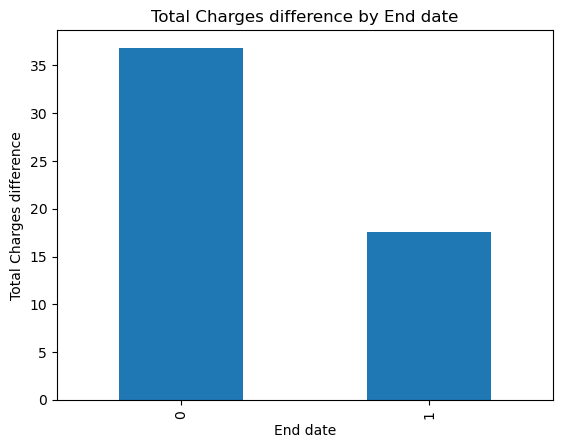

In [49]:
df_consolidado.groupby('end_date_2', observed=False)['total_charges_diff'].mean().plot(kind='bar')
plt.xlabel('End date')
plt.ylabel('Total Charges difference')
plt.title('Total Charges difference by End date')
plt.show()

In [50]:
df_consolidado.groupby('end_date_2', observed=False)['total_charges_diff'].mean()

end_date_2
0    36.847468
1    17.537533
Name: total_charges_diff, dtype: float64

- En el gráfico anterior se da a conocer los cobros adicionales al pago mensual que tiene los clientes de Interconnect.
- Los usuarios que siguen en la compañía, pagan en promedio $37 más sobre el pago mensual desde que contraron el servicio.
- Los usuarios que dejaron de contratar los servicios pagaron $18 más sobres el pago mensual dentro de todo el período que usaron el servicio.

### Analizando los servicios de internet

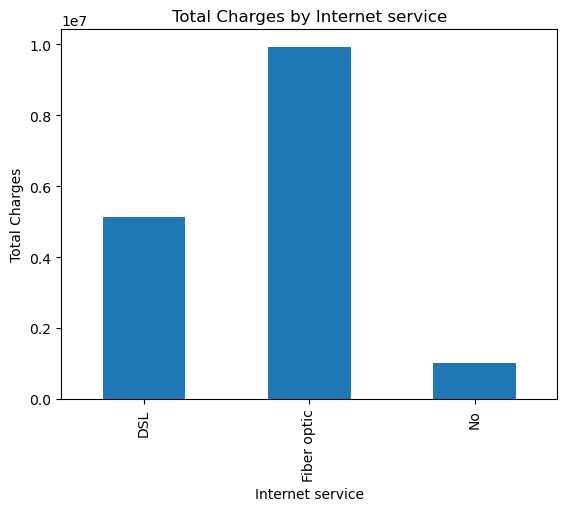

In [51]:
df_consolidado.groupby('internet_service', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Internet service')
plt.ylabel('Total Charges')
plt.title('Total Charges by Internet service')
plt.show()

In [52]:
(df_consolidado.groupby('internet_service', observed=False)['total_charges'].sum() / df_consolidado['total_charges'].sum()) * 100

internet_service
DSL            31.896843
Fiber optic    61.805672
No              6.297486
Name: total_charges, dtype: float64

- Con respecto a tipo de internet que los usuarios prefieren, se ve una alta preferencia por la Fibra óptica, con un 62% del total de ingresos, luego el tipo de internet por DSL con un 32%, y finalmente los que no contrataron el servicio de internet representan el 6%.

In [53]:
print(df_consolidado['online_security'].value_counts())
print()
print(df_consolidado['online_backup'].value_counts())
print()
print(df_consolidado['device_protection'].value_counts())
print()
print(df_consolidado['tech_support'].value_counts())
print()
print(df_consolidado['streaming_tv'].value_counts())
print()
print(df_consolidado['streaming_movies'].value_counts())

online_security
No     5024
Yes    2019
Name: count, dtype: int64

online_backup
No     4614
Yes    2429
Name: count, dtype: int64

device_protection
No     4621
Yes    2422
Name: count, dtype: int64

tech_support
No     4999
Yes    2044
Name: count, dtype: int64

streaming_tv
No     4336
Yes    2707
Name: count, dtype: int64

streaming_movies
No     4311
Yes    2732
Name: count, dtype: int64


- Por otro lado, del total de usarios del dataframe, más de 4000 usuarios, no usan los servicios extras de internet.

### Analizando el dataframe Personal

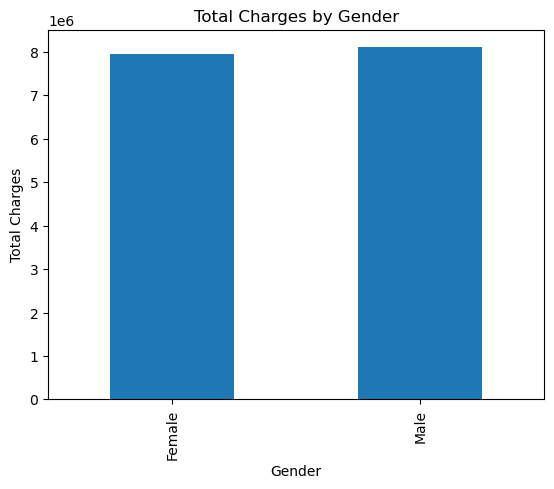

In [54]:
df_consolidado.groupby('gender', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Total Charges')
plt.title('Total Charges by Gender')
plt.show()

In [55]:
(df_consolidado.groupby('gender', observed=False)['total_charges'].sum() / df_consolidado['total_charges'].sum()) * 100

gender
Female    49.528342
Male      50.471658
Name: total_charges, dtype: float64

In [56]:
(df_consolidado['gender'].value_counts() / df_consolidado['gender'].count()) * 100

gender
Male      50.47565
Female    49.52435
Name: count, dtype: float64

- En términos del género del contratane del servicio, el gráfico demuestra que entre el genero feminino y masculino hay 0.5% de diferencia sobre el total de cargos, lo que nos dice que el género de los usuarios del dataframe son practicamente iguales.

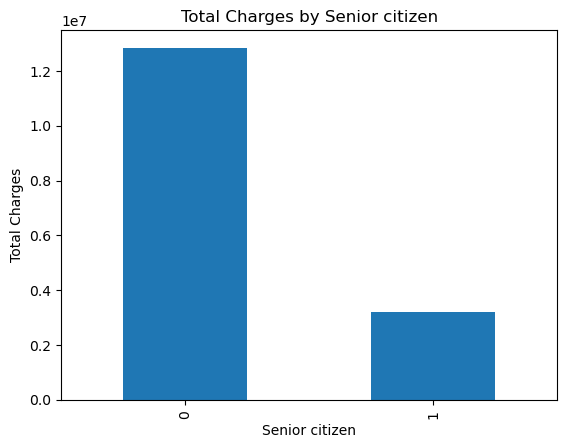

In [57]:
df_consolidado.groupby('senior_citizen', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Senior citizen')
plt.ylabel('Total Charges')
plt.title('Total Charges by Senior citizen')
plt.show()

In [58]:
(df_consolidado['senior_citizen'].value_counts() / df_consolidado['senior_citizen'].count()) * 100

senior_citizen
0    83.785319
1    16.214681
Name: count, dtype: float64

- Sobre los 'senior_citizen' se puede decir que forman parte del 16% del total del dataframe.

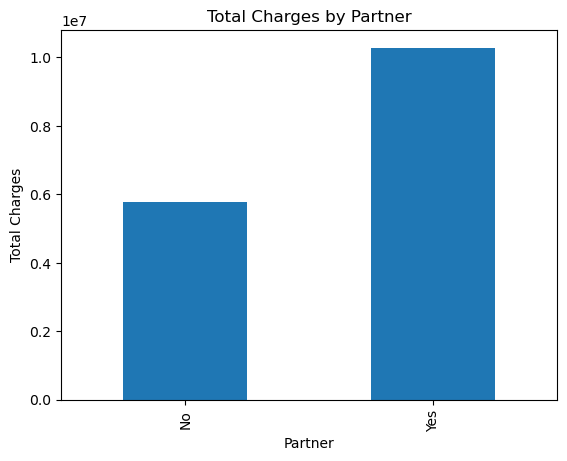

In [59]:
df_consolidado.groupby('partner', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Partner')
plt.ylabel('Total Charges')
plt.title('Total Charges by Partner')
plt.show()

In [60]:
(df_consolidado['partner'].value_counts() / df_consolidado['partner'].count()) * 100

partner
No     51.69672
Yes    48.30328
Name: count, dtype: float64

- Sobre los 'partner' se puede decir que los que no tienen partner forman el 52% del dataframe, contra el 48% que sí tienen partner.

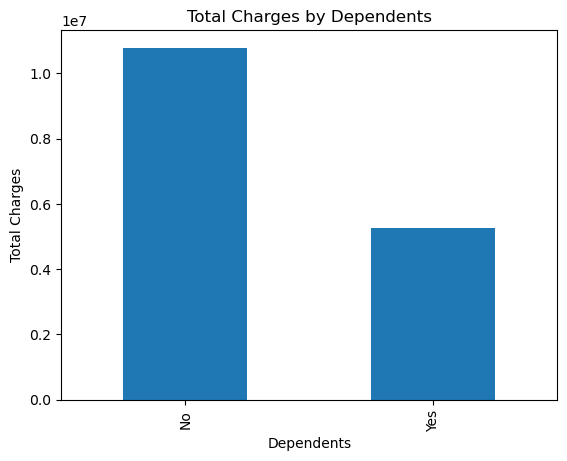

In [61]:
df_consolidado.groupby('dependents', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Dependents')
plt.ylabel('Total Charges')
plt.title('Total Charges by Dependents')
plt.show()

In [62]:
(df_consolidado['dependents'].value_counts() / df_consolidado['dependents'].count()) * 100

dependents
No     70.041176
Yes    29.958824
Name: count, dtype: float64

- Sobre los 'dependents' se puede decir que los que no tienen dependents forman el 70% del dataframe, contra el 30% que sí.

### Analizando el dataframe Phone

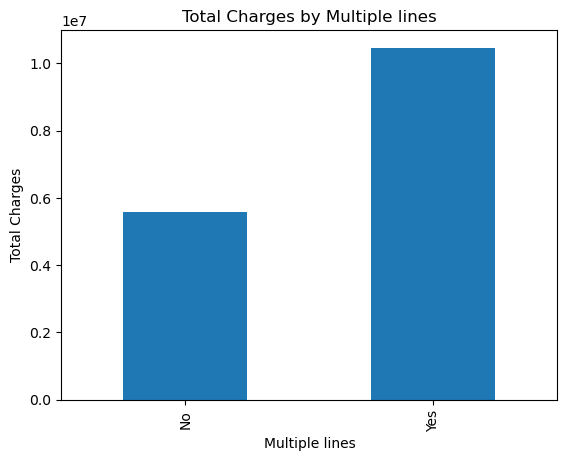

In [63]:
df_consolidado.groupby('multiple_lines', observed=False)['total_charges'].sum().plot(kind='bar')
plt.xlabel('Multiple lines')
plt.ylabel('Total Charges')
plt.title('Total Charges by Multiple lines')
plt.show()

In [64]:
(df_consolidado['multiple_lines'].value_counts() / df_consolidado['multiple_lines'].count()) * 100

multiple_lines
No     57.816271
Yes    42.183729
Name: count, dtype: float64

- Sobre los 'multiple_lines' se puede decir que los que tienen multiple lines forman el 42% del dataframe, contra el 58% que no.

### Analizando la estadía de los usuarios que dejaron la compañía

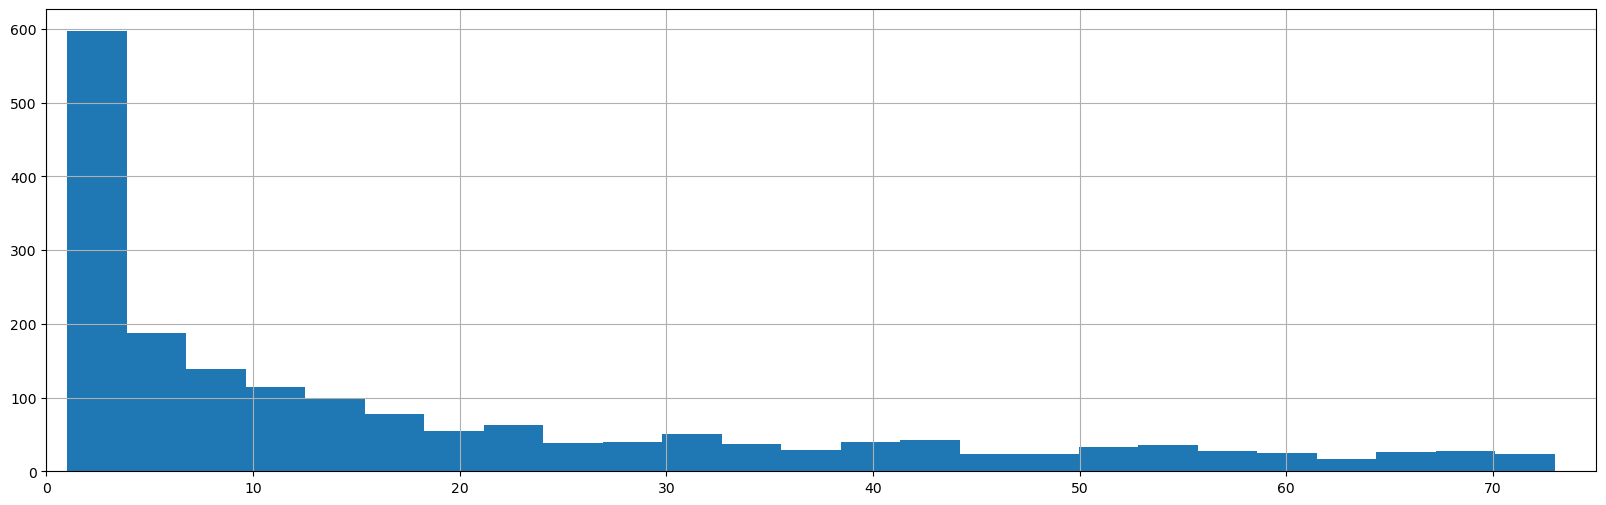

In [65]:
df_consolidado[df_consolidado['end_date_2'] == 1]['months_using_service'].hist(bins=25, figsize=(20, 6))
plt.xlim(0, 75)
plt.show()

In [66]:
print('Meses promedio de uso de usuarios que dejaron la compañía:', round(df_consolidado[df_consolidado['end_date_2'] == 1]['months_using_service'].mean()))
print('Mínimo de meses de uso de usuarios que dejaron la compañía:',df_consolidado[df_consolidado['end_date_2'] == 1]['months_using_service'].min())
print('Máximo de meses de uso de usuarios que dejaron la compañía:',df_consolidado[df_consolidado['end_date_2'] == 1]['months_using_service'].max())
print('Total de usuarios que dejaron la compañía:',df_consolidado[df_consolidado['end_date_2'] == 1]['customer_id'].count())

Meses promedio de uso de usuarios que dejaron la compañía: 18
Mínimo de meses de uso de usuarios que dejaron la compañía: 1
Máximo de meses de uso de usuarios que dejaron la compañía: 73
Total de usuarios que dejaron la compañía: 1869


In [67]:
df_consolidado[df_consolidado['end_date_2'] == 1]['months_using_service'].value_counts() 

months_using_service
1     380
2     123
3      94
4      83
5      64
     ... 
61      6
73      6
63      5
65      4
64      4
Name: count, Length: 72, dtype: int64

In [68]:
(df_consolidado[df_consolidado['end_date_2'] == 1]['months_using_service'].value_counts()  / df_consolidado[df_consolidado['end_date_2'] == 1]['customer_id'].count()) * 100

months_using_service
1     20.331728
2      6.581059
3      5.029428
4      4.440877
5      3.424291
        ...    
61     0.321027
73     0.321027
63     0.267523
65     0.214018
64     0.214018
Name: count, Length: 72, dtype: float64

In [69]:
df_consolidado[df_consolidado['end_date_2'] == 1]['total_charges_diff'].mean() 

17.53753344034243

- Como se muestra en el gráfico, la mayoría de los usuarios que dejaron la compañía, permanecieron menos de 10 meses.
- Un 38% estuvo menos de 5 meses contratando los servicios de la empresa.
- En promedios los usuarios que dejaron la compañía, estuvieron 18 meses.
- Los usuarios que dejaron la compañía pagaron $17 de más sobre su pago mensual.

### Meses de uso del servicio

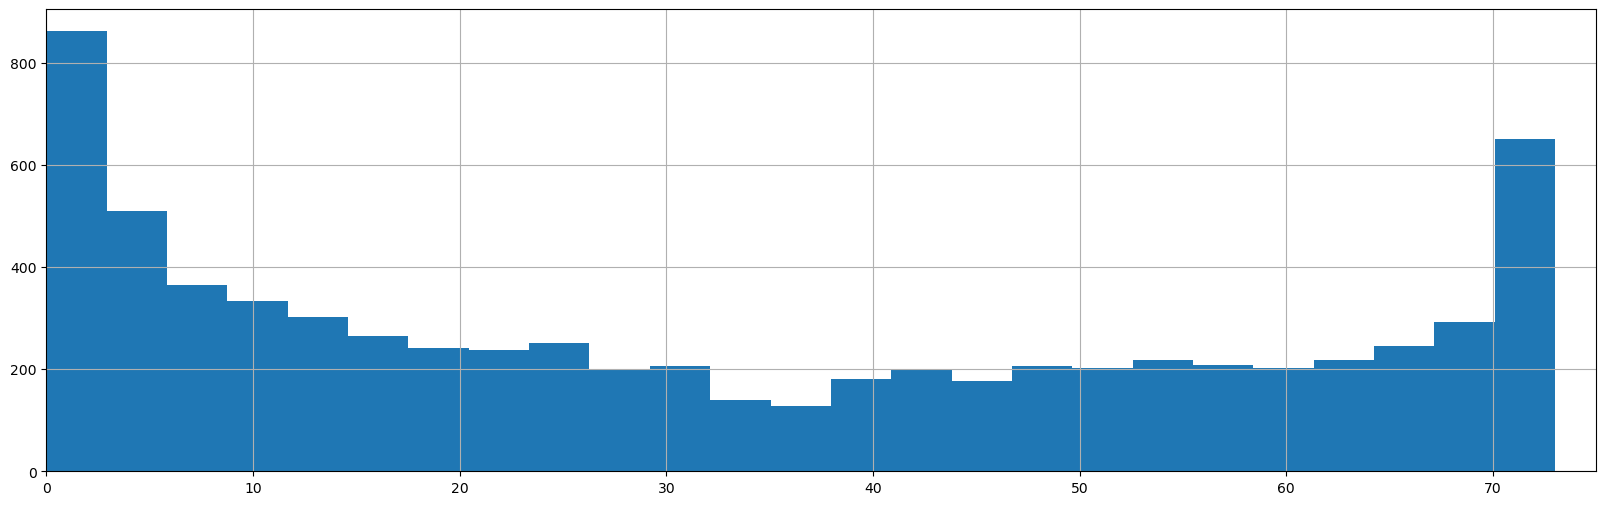

In [70]:
df_consolidado['months_using_service'].hist(bins=25, figsize=(20, 6))
plt.xlim(0, 75)
plt.show()

In [71]:
df_consolidado['months_using_service'].mean()

32.81669743007241

- En el gráfico se puede apreciar que tenemos una gran concentración en usuarios nuevos, los que llevan menos de 12 meses en la compañía, y por otro lado otra gran concentración en usuarios que llevan más de 70 meses en la empresa, ¡esos son más de 5 años!

### Analizando usuarios activos y desactivos

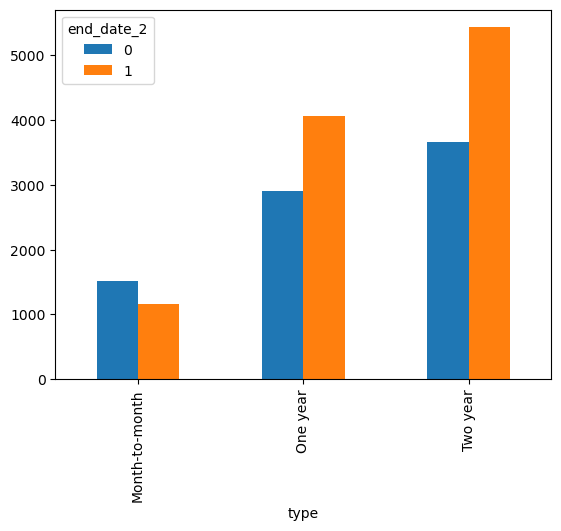

In [72]:
_= df_consolidado.pivot_table(index='type', columns='end_date_2', values='total_charges', aggfunc='mean').plot(kind='bar')

- Los usuarios que dejaron la compañía tenían preferencia por el tipo de pago a 2 años.

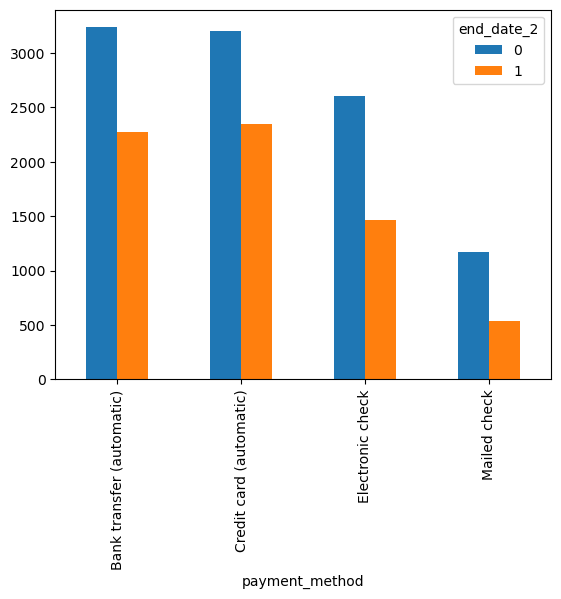

In [73]:
_= df_consolidado.pivot_table(index='payment_method', columns='end_date_2', values='total_charges', aggfunc='mean').plot(kind='bar')

- La tendencia del método de pago es similiar para los usuarios activos y desactivos, ambos prefieron los métodos de pago digitales.

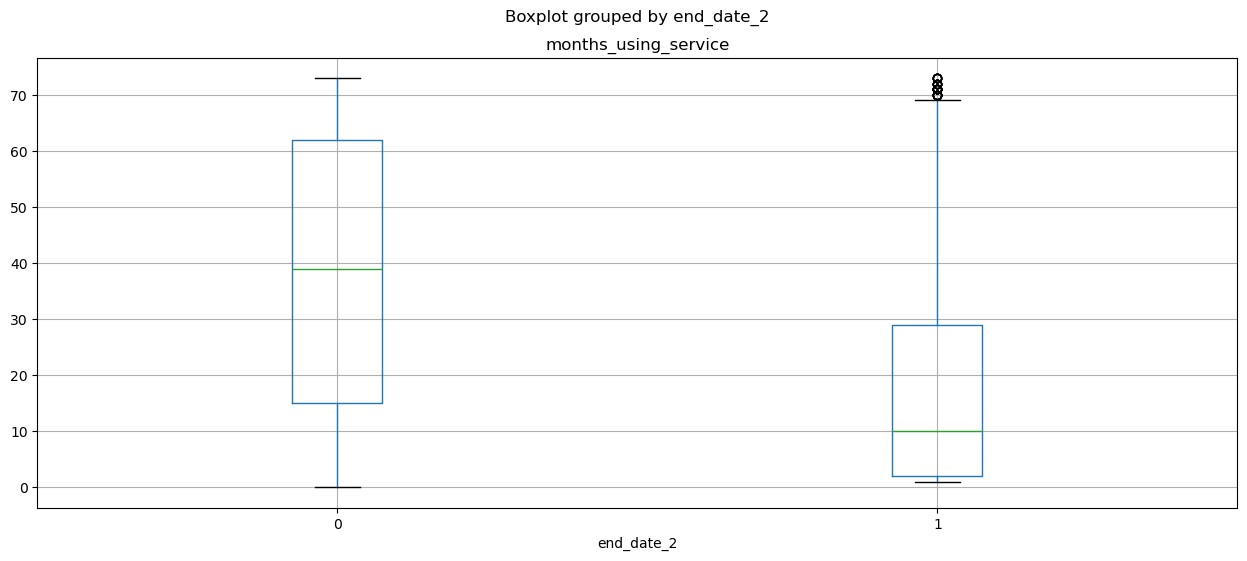

In [74]:
_= df_consolidado.boxplot(column='months_using_service', by='end_date_2', figsize=(15,6))

- Sobre los usuarios que dejaron la compañía tenemos dos grupos marcaddos:
- Usuarios con menos de 10 meses desde que contrataron los servicios de la compañía.
- Usuarios antigüos con más de 70 meses en la compañía, siendo estos además valores atípicos.

### Selección de características para los modelos

- A continuación se definirá que características se usarán para los modelos:

| Variable         | Decisión |
|--------------|--------------|
| customer_id    | No se usará en los modelos porque no influye en el objetivo, dado que es el identificador el usuario.  |
|  begin_date    | No se usará en los modelos porque no influye en el objetivo, dado que es una fecha. |
| end_date  | No se usará en los modelos porque no influye en el objetivo, dado que es una fecha.   |
|  type| Se usará en los modelos porque influye en el objetivo, dado que dependiendo del tipo, el usuario puede dar de baja el servicio desde un mes hasta dos años.  |
| paperless_billing | No se usará en los modelos porque no influye en el objetivo, dado que es una preferencia de cada usuario. |
| payment_method| No se usará en los modelos porque no influye en el objetivo, dado que es una preferencia de cada usuario. |
| monthly_charges | Se usará en los modelos porque influye en el objetivo, dado que es el monto del pago mensual del servicio. |
|  total_charges | Se usará en los modelos porque influye en el objetivo, dado que es el monto del pago total del servicio. |
| internet_service| Se usará en los modelos porque influye en el objetivo, dado que identifica el tipo de internet que el usuario elige. |
| online_security | No se usará en los modelos porque no influye en el objetivo, dado que es un servicio adicional opcional. |
| online_backup| No se usará en los modelos porque no influye en el objetivo, dado que es un servicio adicional opcional. |
| device_protection |No se usará en los modelos porque no influye en el objetivo, dado que es un servicio adicional opcional. |
| tech_support | No se usará en los modelos porque no influye en el objetivo, dado que es un servicio adicional opcional. |
| streaming_tv | No se usará en los modelos porque no influye en el objetivo, dado que es un servicio adicional opcional. |
| streaming_movies | No se usará en los modelos porque no influye en el objetivo, dado que es un servicio adicional opcional. |
| gender | Se usará en los modelos porque influye en el objetivo, dado que identifica el género de cada usuario. |
| senior_citizen |Se usará en los modelos porque influye en el objetivo, dado que identifica si el usuario es senior. |
| partner | No se usará en los modelos porque no influye en el objetivo, dado que es un dato personal de cada usuario. |
| dependents | No se usará en los modelos porque no influye en el objetivo, dado que es un dato personal de cada usuario. |
| multiple_lines | No se usará en los modelos porque no influye en el objetivo, dado que es un servicio adicional opcional. |
| end_date_2 | Objetivo. |
| end_date_3 | No se usará en los modelos porque no influye en el objetivo, dado que es una fecha. |
| months_using_service | Se usará en los modelos porque influye en el objetivo, dado que identifica los meses que el usuario ha usado el servicio. |
| total_charges_diff | Se usará en los modelos porque influye en el objetivo, dado que identifica los cobros extras por sobre el monto mensual. |


- Ahora, se dejarán fuera del dataframe las variables que no se usarán en los modelos.

In [75]:
df_consolidado = df_consolidado.drop(['begin_date', 'end_date', 'paperless_billing', 'payment_method', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
                                      'streaming_movies', 'partner', 'dependents', 'multiple_lines', 'end_date_3'], axis=1)

In [78]:
df_consolidado.head()

,customer_id,type,monthly_charges,total_charges,internet_service,gender,senior_citizen,end_date_2,months_using_service,total_charges_diff
0,7590-VHVEG,Month-to-month,29.85,29.85,DSL,Female,0,0,1,0.00
1,5575-GNVDE,One year,56.95,1889.50,DSL,Male,0,0,34,46.80
2,3668-QPYBK,Month-to-month,53.85,108.15,DSL,Male,0,1,2,-0.45
3,7795-CFOCW,One year,42.30,1840.75,DSL,Male,0,0,46,105.05
4,9237-HQITU,Month-to-month,70.70,151.65,Fiber optic,Female,0,1,2,-10.25


- En el siguiente paso se utilizará One Hot Encoder para los valores de clasificación.

In [79]:
df_consolidado_ohe = pd.get_dummies(df_consolidado[['type', 'internet_service', 'gender']], drop_first=True)

In [81]:
df_consolidado_ohe.head()

,type_One year,type_Two year,internet_service_Fiber optic,internet_service_No,gender_Male
0,False,False,False,False,False
1,True,False,False,False,True
2,False,False,False,False,True
3,True,False,False,False,True
4,False,False,True,False,False


- A continuación se une el dataframe al cual se aplicó el enconder con el resto del dataframe.

In [82]:
df_consolidado = pd.merge(df_consolidado, df_consolidado_ohe, left_index=True, right_index=True, how='outer')

In [83]:
df_consolidado.head()

,customer_id,type,monthly_charges,total_charges,internet_service,gender,senior_citizen,end_date_2,months_using_service,total_charges_diff,type_One year,type_Two year,internet_service_Fiber optic,internet_service_No,gender_Male
0,7590-VHVEG,Month-to-month,29.85,29.85,DSL,Female,0,0,1,0.00,False,False,False,False,False
1,5575-GNVDE,One year,56.95,1889.50,DSL,Male,0,0,34,46.80,True,False,False,False,True
2,3668-QPYBK,Month-to-month,53.85,108.15,DSL,Male,0,1,2,-0.45,False,False,False,False,True
3,7795-CFOCW,One year,42.30,1840.75,DSL,Male,0,0,46,105.05,True,False,False,False,True
4,9237-HQITU,Month-to-month,70.70,151.65,Fiber optic,Female,0,1,2,-10.25,False,False,True,False,False


- A continuación se quitan del dataframe los valores que fueron pasados por el enconder, además del customer id, dado que ya no vamos a unir dataframes.

In [84]:
df_consolidado = df_consolidado.drop(['customer_id', 'type', 'internet_service', 'gender'], axis=1)

In [86]:
df_consolidado.head()

,monthly_charges,total_charges,senior_citizen,end_date_2,months_using_service,total_charges_diff,type_One year,type_Two year,internet_service_Fiber optic,internet_service_No,gender_Male
0,29.85,29.85,0,0,1,0.00,False,False,False,False,False
1,56.95,1889.50,0,0,34,46.80,True,False,False,False,True
2,53.85,108.15,0,1,2,-0.45,False,False,False,False,True
3,42.30,1840.75,0,0,46,105.05,True,False,False,False,True
4,70.70,151.65,0,1,2,-10.25,False,False,True,False,False


- Ahora se separará el dataframe en features, target y df de entrenamiento y validación.

In [87]:
features = df_consolidado.drop(['end_date_2'], axis=1)
target  = df_consolidado['end_date_2']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

- En el siguiente paso se hará un escalado a las variables no booleanas.

In [88]:
numeric = ['monthly_charges', 'total_charges', 'months_using_service', 'total_charges_diff']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])

features_train_scaled = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

# Entrenado los modelos

### Árbol de decisiones

-  Con el siguiente bucle for se pretende encontrar los mejores hiperparámetros para el modelo.

In [90]:
for d in range(1, 20):
    model = DecisionTreeClassifier(random_state=1234, max_depth = d)
    model.fit(features_train, target_train)
    predictions_dtc = model.predict(features_valid)
    print('roc_auc_score:', roc_auc_score(target_valid, predictions_dtc), 'Max depth:', d)

roc_auc_score: 0.5 Max depth: 1
roc_auc_score: 0.6644586074965821 Max depth: 2
roc_auc_score: 0.6644586074965821 Max depth: 3
roc_auc_score: 0.6727916949435936 Max depth: 4
roc_auc_score: 0.6713483422344182 Max depth: 5
roc_auc_score: 0.6897283447916358 Max depth: 6
roc_auc_score: 0.6711835983987883 Max depth: 7
roc_auc_score: 0.6748497634573584 Max depth: 8
roc_auc_score: 0.6631357390851061 Max depth: 9
roc_auc_score: 0.6717442192125737 Max depth: 10
roc_auc_score: 0.6650831587540449 Max depth: 11
roc_auc_score: 0.6680829718804403 Max depth: 12
roc_auc_score: 0.672469583861989 Max depth: 13
roc_auc_score: 0.6563714063714063 Max depth: 14
roc_auc_score: 0.6474875335634829 Max depth: 15
roc_auc_score: 0.643491880833653 Max depth: 16
roc_auc_score: 0.6372734157544284 Max depth: 17
roc_auc_score: 0.6448786796888062 Max depth: 18
roc_auc_score: 0.6406617292693243 Max depth: 19


In [91]:
model_dtc = DecisionTreeClassifier(random_state=1234, max_depth=6)
model_dtc.fit(features_train, target_train)

predictions_dtc = model_dtc.predict(features_valid)

auc_roc_dtc = roc_auc_score(target_valid, predictions_dtc)
accuracy = accuracy_score(target_valid, predictions_dtc)

print("AUC-ROC Score:", auc_roc_dtc)

AUC-ROC Score: 0.6897283447916358


- Con el mejor max_depth (6), el auc-roc es de 0.69, valor que se aleja del exigido por la compañía. El actual score nos dice que este modelo tiene una capacidad de discriminación pobre y es dificilmente útil para la clasifiación.

### Aplicando Sobre y Submuestreo

In [92]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=1234)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

for d in range(1, 20):
    model = DecisionTreeClassifier(random_state=1234, max_depth = d)
    model.fit(features_upsampled, target_upsampled)
    predictions_dtc_upsampled = model.predict(features_valid)
    print('roc_auc_score:', roc_auc_score(target_valid, predictions_dtc_upsampled), 'Max depth:', d)

roc_auc_score: 0.64856943337956 Max depth: 1
roc_auc_score: 0.735138630708251 Max depth: 2
roc_auc_score: 0.7347501303197507 Max depth: 3
roc_auc_score: 0.7639860139860141 Max depth: 4
roc_auc_score: 0.762257433143509 Max depth: 5
roc_auc_score: 0.7437864526472122 Max depth: 6
roc_auc_score: 0.7446126306885799 Max depth: 7
roc_auc_score: 0.7479911087506023 Max depth: 8
roc_auc_score: 0.7271227366164076 Max depth: 9
roc_auc_score: 0.7124654529717821 Max depth: 10
roc_auc_score: 0.7147399014487621 Max depth: 11
roc_auc_score: 0.7131809821683239 Max depth: 12
roc_auc_score: 0.7087402751959714 Max depth: 13
roc_auc_score: 0.6997432946800035 Max depth: 14
roc_auc_score: 0.6897480156973828 Max depth: 15
roc_auc_score: 0.6800305882584363 Max depth: 16
roc_auc_score: 0.6696468088873152 Max depth: 17
roc_auc_score: 0.6551001740875159 Max depth: 18
roc_auc_score: 0.6593736783610201 Max depth: 19


In [93]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=1234)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=1234)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=1234)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

for d in range(1, 20):
    model = DecisionTreeClassifier(random_state=1234, max_depth = d)
    model.fit(features_downsampled, target_downsampled)
    predictions_dtc_downsampled = model.predict(features_valid)
    print('roc_auc_score:', roc_auc_score(target_valid, predictions_dtc_downsampled), 'Max depth:', d)

roc_auc_score: 0.64856943337956 Max depth: 1
roc_auc_score: 0.735138630708251 Max depth: 2
roc_auc_score: 0.735138630708251 Max depth: 3
roc_auc_score: 0.763317203190621 Max depth: 4
roc_auc_score: 0.7412390703529945 Max depth: 5
roc_auc_score: 0.7272456797773253 Max depth: 6
roc_auc_score: 0.7193060104452509 Max depth: 7
roc_auc_score: 0.7150866011625505 Max depth: 8
roc_auc_score: 0.7057035791213006 Max depth: 9
roc_auc_score: 0.6898783354479558 Max depth: 10
roc_auc_score: 0.681385421891751 Max depth: 11
roc_auc_score: 0.6764431068228537 Max depth: 12
roc_auc_score: 0.6740014556470253 Max depth: 13
roc_auc_score: 0.6676698828597563 Max depth: 14
roc_auc_score: 0.660674417003531 Max depth: 15
roc_auc_score: 0.6550682088656773 Max depth: 16
roc_auc_score: 0.662562823955229 Max depth: 17
roc_auc_score: 0.6672248286172336 Max depth: 18
roc_auc_score: 0.6502365426416059 Max depth: 19


In [94]:
model_dtc = DecisionTreeClassifier(random_state=1234, max_depth=4)
model_dtc.fit(features_downsampled, target_downsampled)

predictions_dtc_downsampled = model_dtc.predict(features_valid)

auc_roc_dtc_downsampled = roc_auc_score(target_valid, predictions_dtc_downsampled)

print("AUC-ROC Score:", auc_roc_dtc_downsampled)

AUC-ROC Score: 0.763317203190621


- El Submuestreo tiene un mayor valor auc-roc.
- El score del auc-roc con el submuestreo es de 0.76 el cual es mayor al score original de 0.69.
- Aún así, el score sigue siendo  bajo para lo requerido por la compañía.

### Random Forest Regressor

-  Con el siguiente Grid Search se pretende encontrar los mejores hiperparámetros para el modelo.

In [95]:
model_rfr = RandomForestRegressor(random_state=1234)

param_grid = {
    'n_estimators': [5, 10, 15],
    'max_depth': [2, 4, 8]
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model_rfr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(features_train, target_train)
best_params = grid_search.best_params_
print("Mejores Hiperparámetros:", best_params)
best_model = grid_search.best_estimator_

Mejores Hiperparámetros: {'max_depth': 4, 'n_estimators': 15}


In [96]:
%%time
model_rfr = RandomForestRegressor(random_state=1234, max_depth=4, n_estimators=15)
model_rfr.fit(features_train, target_train)
predictions_rfr = model_rfr.predict(features_valid)

auc_roc_rfr = roc_auc_score(target_valid, predictions_rfr)

print("AUC-ROC Score:", auc_roc_rfr)

AUC-ROC Score: 0.8327694340352568
CPU times: total: 46.9 ms
Wall time: 85.9 ms


- Con este modelo obtenemos un score de 0.83, siendo este un valor superior a los modelos anteriores.
- El valor del score nos dice que el modelo tiene una capacidad de discriminación aceptable y puede ser útil para la clasificación en algunos casos.

### Aplicando Sobre y Submuestreo

In [97]:
model_rfr = RandomForestRegressor(random_state=1234)

param_grid = {
    'n_estimators': [5, 10, 55],
    'max_depth': [2, 4, 40]
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model_rfr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(features_upsampled, target_upsampled)
best_params = grid_search.best_params_
print("Mejores Hiperparámetros:", best_params)
best_model = grid_search.best_estimator_

Mejores Hiperparámetros: {'max_depth': 40, 'n_estimators': 55}


In [98]:
model_rfr = RandomForestRegressor(random_state=1234, max_depth=40, n_estimators=55)
model_rfr.fit(features_upsampled, target_upsampled)
predictions_rfr = model_rfr.predict(features_valid)

auc_roc = roc_auc_score(target_valid, predictions_rfr)

print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.7831307230041408


In [99]:
model_rfr = RandomForestRegressor(random_state=1234)

param_grid = {
    'n_estimators': [5, 10, 55],
    'max_depth': [2, 4, 40]
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model_rfr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(features_downsampled, target_downsampled)
best_params = grid_search.best_params_
print("Mejores Hiperparámetros:", best_params)
best_model = grid_search.best_estimator_

Mejores Hiperparámetros: {'max_depth': 4, 'n_estimators': 55}


In [100]:
model_rfr = RandomForestRegressor(random_state=1234, max_depth=4, n_estimators=55)
model_rfr.fit(features_downsampled, target_downsampled)
predictions_rfr = model_rfr.predict(features_valid)

auc_roc = roc_auc_score(target_valid, predictions_rfr)

print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8309892170651665


- Los sobre y submuestreos en este modelo no generan mejores resultados, para este modelo se recomienda usar la versión original.

### Regresión Lineal

-  Con el siguiente Grid Search se pretende encontrar los mejores hiperparámetros para el modelo.

In [101]:
model_lr = LinearRegression()

param_grid = {
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(features_train, target_train)
best_params = grid_search.best_params_
print("Mejores Hiperparámetros:", best_params)
best_model = grid_search.best_estimator_

Mejores Hiperparámetros: {'fit_intercept': True}


In [102]:
%%time
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)

auc_roc_lr = roc_auc_score(target_valid, predictions_lr)

print("AUC-ROC Score:", auc_roc_lr)

AUC-ROC Score: 0.8301064851697761
CPU times: total: 0 ns
Wall time: 5 ms


- Con este modelo obtenemos un score de 0.83, siendo este un valor superior a los modelos anteriores y similar al RandomForestRegressor.
- El valor del score nos dice que el modelo tiene una capacidad de discriminación aceptable y puede ser útil para la clasificación en algunos casos.
- Si bien es un score similar al de RandomForestRegressor, la velocidad de procesamiento de este modelo, es superior.

### Aplicando sobre y submuestreo

In [103]:
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(features_upsampled, target_upsampled)
predictions_lr = model_lr.predict(features_valid)

auc_roc = roc_auc_score(target_valid, predictions_lr)

print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8345340782049642


In [104]:
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(features_downsampled, target_downsampled)
predictions_lr = model_lr.predict(features_valid)

auc_roc = roc_auc_score(target_valid, predictions_lr)

print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8337619951544003


- Con el sobre y submuestreo la diferencia en de décimas, por lo que se recomiendo usar la versión original del modelo.

### Light GBM

In [105]:
%%time
# Configuración básica del modelo
params = {
    'objective': 'regression',  # Puedes cambiar a 'binary' para clasificación binaria, etc.
    'metric': 'mse',  # MSE (Error Cuadrático Medio) como métrica de evaluación
    'boosting_type': 'gbdt',  # Puedes probar 'dart' o 'goss' también
    'early_stopping_rounds': 10,  # Número de rondas para esperar antes de detener el entrenamiento si no mejora la métrica
}

# Crear conjunto de datos de LightGBM
train_data = lgb.Dataset(features_train, label=target_train)
valid_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data)

# Entrenar el modelo
num_round = 100  # Número de rondas de entrenamiento
model = lgb.train(params, train_data, num_round, valid_sets=[valid_data], valid_names=['test'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.264105
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	test's l2: 0.140816
CPU times: total: 734 ms
Wall time: 54.6 ms


In [106]:
predictions_lgb = model.predict(features_valid, num_iteration=model.best_iteration)
auc_roc_lgbm = roc_auc_score(target_valid, predictions_lgb)
print("AUC-ROC Score:", auc_roc_lgbm)

AUC-ROC Score: 0.8339226408846663


- Con este modelo obtenemos un score de 0.83, siendo este un valor similar a los últimos modelos.
- El valor del score nos dice que el modelo tiene una capacidad de discriminación aceptable y puede ser útil para la clasificación en algunos casos.
- Si bien es un score similar a los últimos modelos, la velocidad de procesamiento de este modelo, es mayor.

### Aplicando sobre y submuestreo

In [107]:
# Configuración básica del modelo
params = {
    'objective': 'regression',  # Puedes cambiar a 'binary' para clasificación binaria, etc.
    'metric': 'mse',  # MSE (Error Cuadrático Medio) como métrica de evaluación
    'boosting_type': 'gbdt',  # Puedes probar 'dart' o 'goss' también
    'early_stopping_rounds': 10,  # Número de rondas para esperar antes de detener el entrenamiento si no mejora la métrica
}

# Crear conjunto de datos de LightGBM
train_data = lgb.Dataset(features_downsampled, label=target_downsampled)
valid_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data)

# Entrenar el modelo
num_round = 100  # Número de rondas de entrenamiento
model = lgb.train(params, train_data, num_round, valid_sets=[valid_data], valid_names=['test'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 2561, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.544709
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	test's l2: 0.186919


In [108]:
predictions_lgb = model.predict(features_valid, num_iteration=model.best_iteration)
auc_roc = roc_auc_score(target_valid, predictions_lgb)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8267870198249945


In [109]:
# Configuración básica del modelo
params = {
    'objective': 'regression',  # Puedes cambiar a 'binary' para clasificación binaria, etc.
    'metric': 'mse',  # MSE (Error Cuadrático Medio) como métrica de evaluación
    'boosting_type': 'gbdt',  # Puedes probar 'dart' o 'goss' también
    'early_stopping_rounds': 10,  # Número de rondas para esperar antes de detener el entrenamiento si no mejora la métrica
}

# Crear conjunto de datos de LightGBM
train_data = lgb.Dataset(features_upsampled, label=target_upsampled)
valid_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data)

# Entrenar el modelo
num_round = 100  # Número de rondas de entrenamiento
model = lgb.train(params, train_data, num_round, valid_sets=[valid_data], valid_names=['test'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 8072, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.518459
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	test's l2: 0.171542


In [110]:
predictions_lgb = model.predict(features_valid, num_iteration=model.best_iteration)
auc_roc = roc_auc_score(target_valid, predictions_lgb)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8319244047092148


- Los sobre y submuestreos en este modelo no generan mejores resultados, para este modelo se recomienda usar la versión original.

### Regresión Logística

-  Con el siguiente Grid Search se pretende encontrar los mejores hiperparámetros para el modelo.

In [111]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularización
    'penalty': ['l1', 'l2'],  # Tipo de regularización
    'solver': ['liblinear', 'saga']  # Algoritmo de optimización
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,  # Número de validaciones cruzadas
    scoring='accuracy',  # Métrica de evaluación
    verbose=1,  # Muestra información detallada
    n_jobs=-1  # Utiliza todos los núcleos de CPU disponibles
)

# Entrenar el objeto GridSearchCV
grid_search.fit(features_train, target_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Mejores parámetros:", best_params)
print("Mejor modelo:", best_model)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor modelo: LogisticRegression(C=10, solver='liblinear')


In [112]:
#model_log_r = LogisticRegression(random_state=1234, C=10, penalty='l2', solver='liblinear')
model_log_r = LogisticRegression(random_state=1234, C=10, penalty='l2', class_weight='balanced', solver='liblinear')
#model_log_r = LogisticRegression(random_state=1234, class_weight='balanced', solver='liblinear'
model_log_r.fit(features_train, target_train)
predictions_log_r = model_log_r.predict(features_valid)
auc_roc = roc_auc_score(target_valid, predictions_log_r)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.7571577508286369


- Se usan los mejores hiperparámetros para este modelo: C=10, penalty='l2', class_weight='balanced', solver='liblinear'.
- El auc-roc para el modelo es de 0.69, valor que se aleja del exigido por la compañía.
- El actual score nos dice que este modelo tiene una capacidad de discriminación pobre y es dificilmente útil para la clasifiación.

### Aplicando sobre y submuestreo

In [113]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularización
    'penalty': ['l1', 'l2'],  # Tipo de regularización
    'solver': ['liblinear', 'saga']  # Algoritmo de optimización
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,  # Número de validaciones cruzadas
    scoring='accuracy',  # Métrica de evaluación
    verbose=1,  # Muestra información detallada
    n_jobs=-1  # Utiliza todos los núcleos de CPU disponibles
)

# Entrenar el objeto GridSearchCV
grid_search.fit(features_upsampled, target_upsampled)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Mejores parámetros:", best_params)
print("Mejor modelo:", best_model)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Mejor modelo: LogisticRegression(C=1, penalty='l1', solver='saga')


In [114]:
#model_log_r = LogisticRegression(random_state=1234, C=10, penalty='l2', solver='liblinear')
model_log_r = LogisticRegression(random_state=1234, C=1, penalty='l1', class_weight='balanced', solver='saga')
#model_log_r = LogisticRegression(random_state=1234, class_weight='balanced', solver='liblinear'
model_log_r.fit(features_upsampled, target_upsampled)
predictions_log_r = model_log_r.predict(features_valid)
auc_roc = roc_auc_score(target_valid, predictions_log_r)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.7559922496631357


In [115]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularización
    'penalty': ['l1', 'l2'],  # Tipo de regularización
    'solver': ['liblinear', 'saga']  # Algoritmo de optimización
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,  # Número de validaciones cruzadas
    scoring='accuracy',  # Métrica de evaluación
    verbose=1,  # Muestra información detallada
    n_jobs=-1  # Utiliza todos los núcleos de CPU disponibles
)

# Entrenar el objeto GridSearchCV
grid_search.fit(features_downsampled, target_downsampled)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Mejores parámetros:", best_params)
print("Mejor modelo:", best_model)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor modelo: LogisticRegression(C=0.1, solver='liblinear')


In [116]:
#model_log_r = LogisticRegression(random_state=1234, C=10, penalty='l2', solver='liblinear')
model_log_r = LogisticRegression(random_state=1234, C=0.1, penalty='l2', class_weight='balanced', solver='liblinear')
#model_log_r = LogisticRegression(random_state=1234, class_weight='balanced', solver='liblinear'
model_log_r.fit(features_upsampled, target_upsampled)
predictions_log_r_upsampled = model_log_r.predict(features_valid)
auc_roc_log_r_upsampled = roc_auc_score(target_valid, predictions_log_r_upsampled)
print("AUC-ROC Score:", auc_roc_log_r_upsampled)

AUC-ROC Score: 0.7588224012274646


- Los sobre y submuestreos en este modelo no generan mejores resultados, para este modelo se recomienda usar la versión original.

### XGBClassifier

In [117]:
%%time
# Configurar los parámetros del modelo
params = {
    'objective': 'binary:logistic',  # Problema de clasificación binaria
    'eval_metric': 'logloss',  # Métrica de evaluación para la clasificación
    'early_stopping_rounds': 10,  # Detener el entrenamiento si no mejora después de 10 iteraciones
    # Puedes agregar más parámetros según sea necesario
}

model = XGBClassifier(**params)
model.fit(features_train, target_train, eval_set=[(features_valid, target_valid)])
predictions_xgb = model.predict_proba(features_valid)[:, 1]
auc_roc_xgb = roc_auc_score(target_valid, predictions_xgb)
print("AUC-ROC Score:", auc_roc_xgb)

[0]	validation_0-logloss:0.51359
[1]	validation_0-logloss:0.48100
[2]	validation_0-logloss:0.46072
[3]	validation_0-logloss:0.44707
[4]	validation_0-logloss:0.44121
[5]	validation_0-logloss:0.43766
[6]	validation_0-logloss:0.43663
[7]	validation_0-logloss:0.43643
[8]	validation_0-logloss:0.43656
[9]	validation_0-logloss:0.43586
[10]	validation_0-logloss:0.43573
[11]	validation_0-logloss:0.43590
[12]	validation_0-logloss:0.43739
[13]	validation_0-logloss:0.43766
[14]	validation_0-logloss:0.43701
[15]	validation_0-logloss:0.43801
[16]	validation_0-logloss:0.43861
[17]	validation_0-logloss:0.43936
[18]	validation_0-logloss:0.43980
[19]	validation_0-logloss:0.43942
AUC-ROC Score: 0.8294860320176776
CPU times: total: 656 ms
Wall time: 62.1 ms


- Con este modelo obtenemos un score de 0.83.

### Aplicando sobre y submuestreo

In [118]:
%%time
# Configurar los parámetros del modelo
params = {
    'objective': 'binary:logistic',  # Problema de clasificación binaria
    'eval_metric': 'logloss',  # Métrica de evaluación para la clasificación
    'early_stopping_rounds': 10,  # Detener el entrenamiento si no mejora después de 10 iteraciones
    # Puedes agregar más parámetros según sea necesario
}

model = XGBClassifier(**params)
model.fit(features_upsampled, target_upsampled, eval_set=[(features_valid, target_valid)])
predictions_xgb = model.predict_proba(features_valid)[:, 1]
auc_roc_xgb = roc_auc_score(target_valid, predictions_xgb)
print("AUC-ROC Score:", auc_roc_xgb)

[0]	validation_0-logloss:0.61868
[1]	validation_0-logloss:0.57160
[2]	validation_0-logloss:0.54467
[3]	validation_0-logloss:0.52871
[4]	validation_0-logloss:0.51870
[5]	validation_0-logloss:0.51403
[6]	validation_0-logloss:0.51104
[7]	validation_0-logloss:0.51053
[8]	validation_0-logloss:0.50888
[9]	validation_0-logloss:0.50851
[10]	validation_0-logloss:0.50536
[11]	validation_0-logloss:0.50575
[12]	validation_0-logloss:0.50566
[13]	validation_0-logloss:0.50586
[14]	validation_0-logloss:0.50709
[15]	validation_0-logloss:0.50700
[16]	validation_0-logloss:0.50615
[17]	validation_0-logloss:0.50424
[18]	validation_0-logloss:0.50294
[19]	validation_0-logloss:0.50289
[20]	validation_0-logloss:0.50356
[21]	validation_0-logloss:0.50229
[22]	validation_0-logloss:0.50294
[23]	validation_0-logloss:0.50346
[24]	validation_0-logloss:0.50399
[25]	validation_0-logloss:0.50596
[26]	validation_0-logloss:0.50603
[27]	validation_0-logloss:0.50710
[28]	validation_0-logloss:0.50809
[29]	validation_0-loglos

In [119]:
%%time
# Configurar los parámetros del modelo
params = {
    'objective': 'binary:logistic',  # Problema de clasificación binaria
    'eval_metric': 'logloss',  # Métrica de evaluación para la clasificación
    'early_stopping_rounds': 10,  # Detener el entrenamiento si no mejora después de 10 iteraciones
    # Puedes agregar más parámetros según sea necesario
}

model = XGBClassifier(**params)
model.fit(features_downsampled, target_downsampled, eval_set=[(features_valid, target_valid)])
predictions_xgb = model.predict_proba(features_valid)[:, 1]
auc_roc_xgb = roc_auc_score(target_valid, predictions_xgb)
print("AUC-ROC Score:", auc_roc_xgb)

[0]	validation_0-logloss:0.65281
[1]	validation_0-logloss:0.60375
[2]	validation_0-logloss:0.58206
[3]	validation_0-logloss:0.56839
[4]	validation_0-logloss:0.55828
[5]	validation_0-logloss:0.55431
[6]	validation_0-logloss:0.55341
[7]	validation_0-logloss:0.55466
[8]	validation_0-logloss:0.55701
[9]	validation_0-logloss:0.55756
[10]	validation_0-logloss:0.55875
[11]	validation_0-logloss:0.55980
[12]	validation_0-logloss:0.56066
[13]	validation_0-logloss:0.56242
[14]	validation_0-logloss:0.56183
[15]	validation_0-logloss:0.56077
AUC-ROC Score: 0.8253641576426386
CPU times: total: 766 ms
Wall time: 57.8 ms


- Los sobre y submuestreos en este modelo no generan mejores resultados, para este modelo se recomienda usar la versión original.

### KNeighborsClassifier

In [120]:
model_knn = KNeighborsClassifier(n_neighbors=100)
model_knn.fit(features_train, target_train)
predictions_knn = model_knn.predict_proba(features_valid)[:, 1]
auc_roc_kn = roc_auc_score(target_valid, predictions_knn)
print("AUC-ROC Score:", auc_roc_kn)

AUC-ROC Score: 0.8267755451299755


- Con este modelo obtenemos un score de 0.826.

### Aplicando sobre y submuestreo

In [121]:
model_knn = KNeighborsClassifier(n_neighbors=100)
model_knn.fit(features_upsampled, target_upsampled)
predictions_knn = model_knn.predict_proba(features_valid)[:, 1]
auc_roc_kn = roc_auc_score(target_valid, predictions_knn)
print("AUC-ROC Score:", auc_roc_kn)

AUC-ROC Score: 0.8290237657326264


In [122]:
model_knn = KNeighborsClassifier(n_neighbors=100)
model_knn.fit(features_downsampled, target_downsampled)
predictions_knn = model_knn.predict_proba(features_valid)[:, 1]
auc_roc_kn = roc_auc_score(target_valid, predictions_knn)
print("AUC-ROC Score:", auc_roc_kn)

AUC-ROC Score: 0.8210644254948053


- Los sobre y submuestreos en este modelo no generan mejores resultados, para este modelo se recomienda usar la versión original.

### MLPClassifier

In [123]:
model_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=1234)
model_mlp.fit(features_train, target_train)
predictions_mlp = model_mlp.predict_proba(features_valid)[:, 1]
auc_roc_mlp = roc_auc_score(target_valid, predictions_mlp)
print("AUC-ROC Score:", auc_roc_mlp)

AUC-ROC Score: 0.8147861280772675


c:\Users\antho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


- Con este modelo obtenemos un score de 0.81.

### Aplicando sobre y submuestreo

In [124]:
model_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=1234)
model_mlp.fit(features_upsampled, target_upsampled)
predictions_mlp = model_mlp.predict_proba(features_valid)[:, 1]
auc_roc_mlp = roc_auc_score(target_valid, predictions_mlp)
print("AUC-ROC Score:", auc_roc_mlp)

AUC-ROC Score: 0.8069816962222026


c:\Users\antho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [125]:
model_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=1234)
model_mlp.fit(features_downsampled, target_downsampled)
predictions_mlp = model_mlp.predict_proba(features_valid)[:, 1]
auc_roc_mlp = roc_auc_score(target_valid, predictions_mlp)
print("AUC-ROC Score:", auc_roc_mlp)

AUC-ROC Score: 0.8082422734321468


c:\Users\antho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


- Los sobre y submuestreos en este modelo no generan mejores resultados, para este modelo se recomienda usar la versión original.

### Resultados

In [126]:
print('AUC-ROC Árbol de decisiones:', round(auc_roc_dtc_downsampled,2))
print('AUC-ROC Regresión Bosque Aleatorio:', round(auc_roc_rfr,2))
print('AUC-ROC Regresión Lineal:', round(auc_roc_lr,2))
print('AUC-ROC Light GBM:', round(auc_roc_lgbm,2))
print('AUC-ROC Regresión Logística:', round(auc_roc_log_r_upsampled,2))
print('AUC-ROC XGB Classifier:', round(auc_roc_xgb,2))
print('AUC-ROC KNeighbors Classifier:', round(auc_roc_kn,2))
print('AUC-ROC MLP Classifier:', round(auc_roc_mlp,2))

AUC-ROC Árbol de decisiones: 0.76
AUC-ROC Regresión Bosque Aleatorio: 0.83
AUC-ROC Regresión Lineal: 0.83
AUC-ROC Light GBM: 0.83
AUC-ROC Regresión Logística: 0.76
AUC-ROC XGB Classifier: 0.83
AUC-ROC KNeighbors Classifier: 0.82
AUC-ROC MLP Classifier: 0.81


### Modelo Final

- Se decide utilizar como modelo final, la Regresión Lineal, porque es de las más utilizadas y además por el tiempo de procesamiento que tiene, siendo uno de los más rápidos en procesar el modelo.

In [127]:
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)

auc_roc_lr = roc_auc_score(target_valid, predictions_lr)

print("AUC-ROC Score:", auc_roc_lr)

AUC-ROC Score: 0.8301064851697761


### Conclusiones Generales

- Este proyecto se inicia con una introducción del problema que se quiere resolver.
- Seguido, se importan las librerías y los 4 dataframes que se utilizarán en el proyecto.
- Luego se encuentra el análisis exploratorio de cada dataframe, en donde se abordan los tipos de variables y valores ausentes.
- Finalizado el paso anterior se unen todos los dataframes, y se proceden a corregir formatos, con el fin de obtener un mejor rendimiento de procesamiento.
- El rellenar los valores ausentes fue el siguiente paso.
- Seguido, se crea una función para 'end_date' con el fin de crear un valor booleano para identifcar a los activos de los que abandonaron la compañía. Esta columna será usado como nuevo 'target'.
- Avanzando a través del proyecto se encuentraa luego el análisis a través de gráficos, se destaca que lo usuarios que dejaron de usar los servicios aportaron un 18% de la venta total, también que el método de pago de preferencia es el de 'Two year', y que el 67% prefiere facturación electrónica.
- Otro dato relevante es que la concentración de usuarios nuevos y antiguos es muy notoria, eso quiere decir usuarios con menos de 12 meses en la compañía o con más de 5 años.
- Para el entrenamiento de los modelos se utilizarán 8 características.
- Se entrenaron 8 modelos.
- Para cada modelo se utilizó el análisis a través del sub y sobremuestreo.
- 5 de los modelos arrojaron un auc-roc de 0.83.
- Dado la versatilidad y rapidez de procesamiento del modelo, se elige como mejor modelo la Regresión Lineal.